# Let's perform inference!
<!--- @wandbcode{ethz-hackathon} -->


In [1]:
from pathlib import Path
from types import SimpleNamespace
import torch, wandb
from miniminiai import show_images
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler

You need to load the original model weights first:

In [2]:

config = SimpleNamespace(
    model_base="runwayml/stable-diffusion-v1-5",
    device="cuda",
)

WANDB_PROJECT_NAME="ethz-hackathon"
LORA_WEIGHTS_AT="capecape/ethz-hackathon/6a6wsrsl_lora:v0"

Create the diffusion Pipeline

In [3]:

pipe = DiffusionPipeline.from_pretrained(config.model_base, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

/opt/conda/lib/python3.8/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Let's create a W&B run

In [4]:
run = wandb.init(project=WANDB_PROJECT_NAME, job_type="inference", group="lora", config=config)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: joebaumann (joe-playground). Use `wandb login --relogin` to force relogin


Let's create a Table to keep track of all our generations

In [5]:
table = wandb.Table(columns=["image", "num_inference_steps", "guidance_scale", "cross_attn_scale"])

Load the LoRA attention weights on top of the pretrained Stable Diffusion model

In [6]:
at = run.use_artifact(LORA_WEIGHTS_AT, type="model")
lora_model_path = list(Path(at.download()).glob("*.bin"))[0]

wandb:   1 of 1 files downloaded.  


In [9]:
# older diffusers style loading
pipe.unet.load_attn_procs(lora_model_path)

# new diffusers and Dreambooth style loading
# pipe.load_attn_procs(lora_model_path)
pipe.to(config.device);

Define some prompts

In [10]:
prompts = ["A pokemon with blue eyes.", 
           "A pokemon that looks like a dog", 
           "a pokemon that smiles a lot", 
           "a sea pokemon in the form of a star"]

Generating with 50% conditioning (interpolating base weights and LoRA weigths)

In [11]:
def generate_images(prompts, num_inference_steps=25, guidance_scale=7.5, cross_attn_scale=0.5):
    images = pipe(
        prompts,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        cross_attention_kwargs={"scale": cross_attn_scale},
    ).images
    for img in images:
        table.add_data(wandb.Image(img),  num_inference_steps, guidance_scale, cross_attn_scale)
    return images

  0%|          | 0/25 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


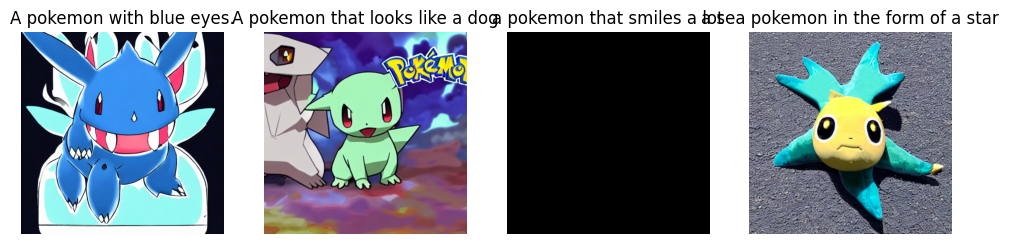

In [12]:
images = generate_images(prompts)
show_images(images, titles=prompts, nrows=1)

  0%|          | 0/25 [00:00<?, ?it/s]

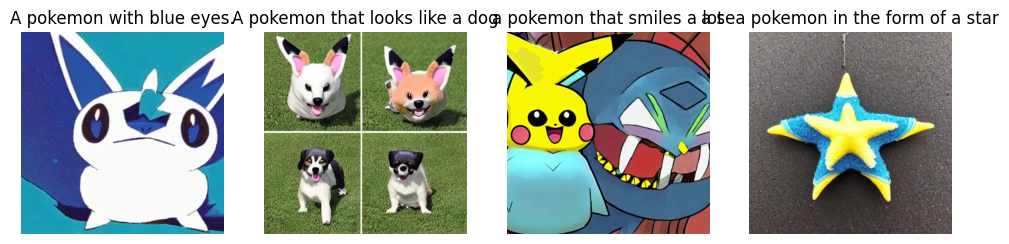

In [14]:
# Full LoRA
images = generate_images(prompts, cross_attn_scale=0.01)
show_images(images, titles=prompts, nrows=1)

  0%|          | 0/25 [00:00<?, ?it/s]

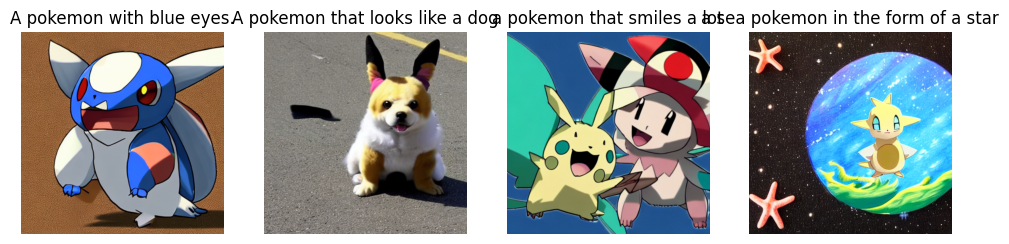

In [15]:
# Full LoRA
images = generate_images(prompts, cross_attn_scale=0)
show_images(images, titles=prompts, nrows=1)

  0%|          | 0/25 [00:00<?, ?it/s]

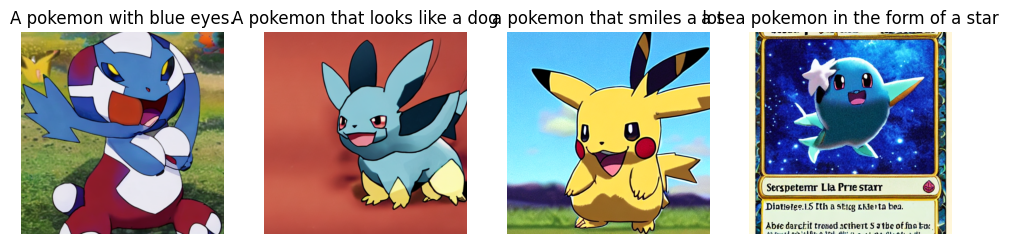

In [16]:
# Full LoRA
images = generate_images(prompts, cross_attn_scale=0.2)
show_images(images, titles=prompts, nrows=1)

  0%|          | 0/25 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


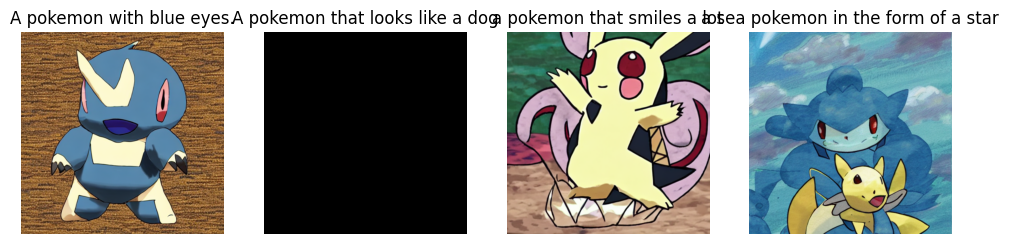

In [17]:
# Full LoRA
images = generate_images(prompts, cross_attn_scale=1)
show_images(images, titles=prompts, nrows=1)

100%|██████████| 25/25 [00:05<00:00,  4.49it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


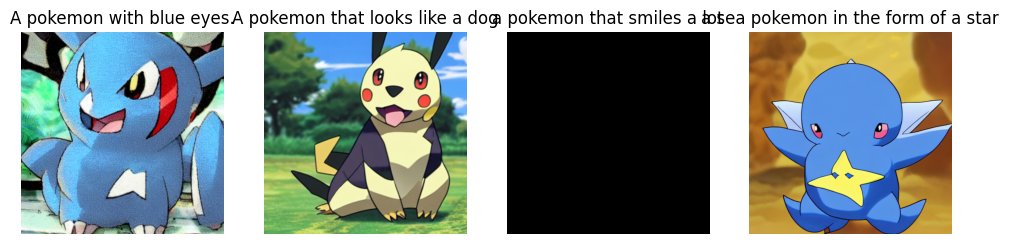

In [27]:
images = generate_images(prompts)
show_images(images, titles=prompts, nrows=1)

Full LoRA

100%|██████████| 25/25 [00:05<00:00,  4.50it/s]


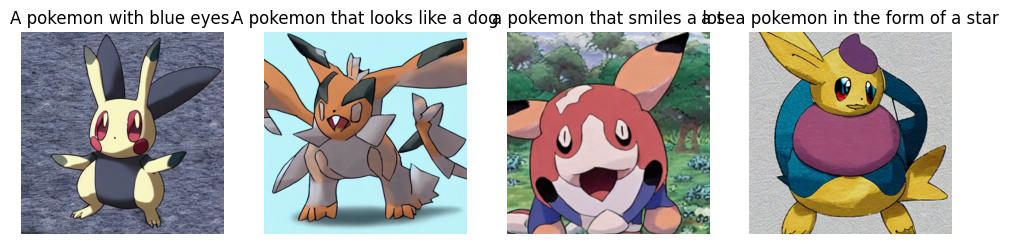

In [28]:

images = generate_images(prompts, cross_attn_scale=1.0)
show_images(images, titles=prompts, nrows=1)